<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Setting-up" data-toc-modified-id="Setting-up-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Setting up</a></span><ul class="toc-item"><li><span><a href="#Rename-some-columns" data-toc-modified-id="Rename-some-columns-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Rename some columns</a></span></li></ul></li></ul></li><li><span><a href="#Gender-repartition-per-countries" data-toc-modified-id="Gender-repartition-per-countries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gender repartition per countries</a></span></li><li><span><a href="#Gender-repartition-in-academic-field" data-toc-modified-id="Gender-repartition-in-academic-field-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gender repartition in academic field</a></span><ul class="toc-item"><li><span><a href="#Setting-up" data-toc-modified-id="Setting-up-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Setting up</a></span></li><li><span><a href="#Which-field-for-which-gender" data-toc-modified-id="Which-field-for-which-gender-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Which field for which gender</a></span></li><li><span><a href="#Leading-role" data-toc-modified-id="Leading-role-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Leading role</a></span><ul class="toc-item"><li><span><a href="#All" data-toc-modified-id="All-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>All</a></span></li></ul></li></ul></li><li><span><a href="#Difference-in-satisfaction-at-work" data-toc-modified-id="Difference-in-satisfaction-at-work-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Difference in satisfaction at work</a></span><ul class="toc-item"><li><span><a href="#Setting-up" data-toc-modified-id="Setting-up-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Setting up</a></span><ul class="toc-item"><li><span><a href="#Plotting-the-different-likert-scale-by-gender" data-toc-modified-id="Plotting-the-different-likert-scale-by-gender-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Plotting the different likert scale by gender</a></span></li></ul></li><li><span><a href="#Aggregating-the-items" data-toc-modified-id="Aggregating-the-items-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Aggregating the items</a></span></li><li><span><a href="#References" data-toc-modified-id="References-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>References</a></span></li></ul></li></ul></div>

# Introduction

## Setting up

In [185]:
#%pwd  #look at the current work dir
#%cd   #change to the dir you want 

In [186]:
import itertools
import string
import csv
from scipy.stats import zscore
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [187]:
import sys
from pathlib import Path
sys.path.append(str(Path('./../../').absolute().parent))
try:
    from include.likertScalePlot import likert_scale
    from include.textCleaning import plot_wordcloud as wordcloud
    from include.textCleaning import wrap_clean_text
except ModuleNotFoundError:
    sys.path.append(str(Path('./../../..').absolute().parent))
    from include.likertScalePlot import likert_scale
    from include.textCleaning import plot_wordcloud as wordcloud
    from include.textCleaning import wrap_clean_text

In [188]:
%%capture 
# Import notebook containing the imports the functions and the dataset
%run "../0. Imports and functions.ipynb"

# Import notebook containing sampled dataset
%run "../1. Overview and sampling.ipynb"

In [189]:
common_columns = ['Country', 'Year']

In [190]:
# Only taking the 2018 results
df = df[df['Year'] == 2018]
# Drop columns with nan values 
df.dropna(how='all', axis=1, inplace=True)

### Rename some columns

In [191]:
df.rename(columns={'satisGen1. In general, how satisfied are you with your current position':'Satisfaction current position', 
                   'satisGen2. In general, how satisfied are you with your career':'Satisfaction with career',
                   'rse4de. Does the majority of your role comprise leading a group of software developers or RSEs?': 'Leading RSE group'}, inplace=True)

# Gender repartition per countries

In [192]:
# rename the column for readiblity
df.rename(columns={"socio2. Please select your gender": "Gender"}, inplace=True)

In [193]:
# Getting the count of the gender per countries
gender_per_country = df.groupby('Country')["Gender"].value_counts().to_frame()
gender_per_country.columns = ['Count']
gender_per_country = gender_per_country.reset_index()
gender_per_country = gender_per_country.pivot(values='Count', index='Country', columns='Gender')
gender_per_country.loc['Total'] = gender_per_country.sum(axis=0)
gender_per_country.replace({np.nan: -1}, inplace=True)
gender_per_country = gender_per_country.astype(int)
gender_per_country.replace({-1: np.nan}, inplace=True)
#gender_per_country = gender_per_country.astype(str)
gender_per_country
gender_per_country.to_csv('./gender_difference/data/gender_per_country.csv', index=True)

Gender,Female,Male,Other,Prefer not to say
Country,,,,
Australia,12.0,69.0,NaN,3.0
Germany,27.0,243.0,NaN,11.0
Netherlands,4.0,43.0,NaN,2.0
New Zealand,3.0,31.0,NaN,NaN
South Africa,2.0,17.0,NaN,NaN
United Kingdom,29.0,162.0,1.0,11.0
United States,29.0,98.0,3.0,4.0
World,3.0,37.0,NaN,NaN
Total,109.0,700.0,4.0,31.0


In [194]:
# Dropping `Prefer not to say` and `Other` for the percentage
gender_per_country.drop(['Prefer not to say', 'Other'], axis=1, inplace=True)
# Dropping `Prefer not to say` and `Other` for further analysis
df = df[(df['Gender'] == 'Male') | (df['Gender'] == 'Female')]

In [195]:
gender_per_country_perc = gender_per_country.apply(lambda x: x/x.sum()*100, axis=1)
gender_per_country_perc
gender_per_country_perc.to_csv('./gender_difference/data/gender_per_country_perc.csv', index=True)

Gender,Female,Male
Country,,
Australia,14.814815,85.185185
Germany,10.000000,90.000000
Netherlands,8.510638,91.489362
New Zealand,8.823529,91.176471
South Africa,10.526316,89.473684
United Kingdom,15.183246,84.816754
United States,22.834646,77.165354
World,7.500000,92.500000
Total,13.473424,86.526576


In [196]:
def plot_bar_gender(df, title, x_title, y_title, type_bar='barh'):

    ## Plotting percentage of gender per country
    ax = df.plot(kind=type_bar, stacked=True, width=1, edgecolor='white', color=['darkcyan', 'bisque'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.suptitle(title, fontsize=20, color='grey')

   

    if type_bar == 'barh':
        x_title, y_title = y_title, x_title

    ax.set_ylabel(y_title, fontsize=18, color='grey')
    ax.tick_params(axis='y', colors='grey', labelsize=18)

    ax.set_xlabel(x_title, fontsize=18, color='grey')
    ax.tick_params(axis='x', colors='grey', labelsize=18)

    ax.legend(bbox_to_anchor=(1., 0.5), fontsize=14, loc='center left',ncol=1, fancybox=True, shadow=True)
    if type_bar == 'barh':
        ax.invert_yaxis()
    rects = ax.patches

    # For each bar: Place a label
    for rect in rects:
        vspace=0
        hspace=0
        va = 'top'
        ha='right'
        if type_bar == 'barh':
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() /2
            label = "{:.0f}%".format(x_value)

            if x_value < 50:
                label_color = 'white'
                va='center'
                hspace = -5
            else:
                x_value = 95
                va='center'
                label_color = 'grey'
        else:
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2
            label = "{:.0f}%".format(y_value)
            if y_value < 25:
                # Number of points between bar and label
                # Invert space to place label below
                vspace = -5
                ha='center'
                label_color='white'
            elif y_value > 25:
                ha='center'
                y_value = 90
                label_color='grey'
        # Create annotation
        ax.annotate(label,                       # Use `label` as label
                    (x_value, y_value),          # Place label at end of the bar
                    xytext=(hspace, vspace),     # Vertically shift label by `space`
                    textcoords="offset points",   # Interpret `xytext` as offset in points
                    ha=ha,                       # Horizontally center label
                    va=va,                       # Vertically align label differently for
                    color=label_color, fontsize=16)                     
                                            
    plt.margins(x=0, y=0)
    plt.savefig('./gender_difference/plots/gender_per_country_perc.png')
    return plt#.tight_layout();

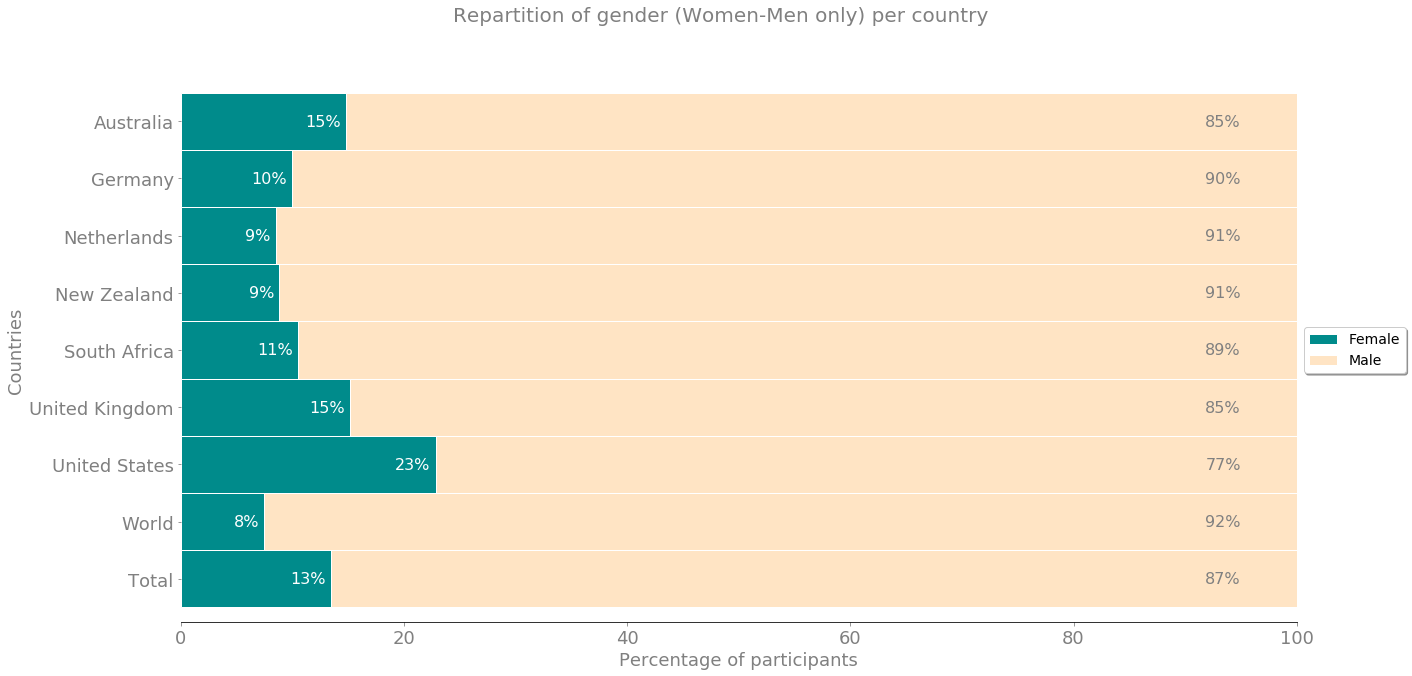

In [197]:
plot_bar_gender(gender_per_country_perc, title='Repartition of gender (Women-Men only) per country', x_title = 'Countries', y_title = 'Percentage of participants' );

# Gender repartition in academic field

## Setting up

In [198]:
## Replace the value of the different field with the JACS level 1 field. This information is found in a created file where the different
## fields used in the survey are match with the corresponding JACS level.

# Create the dictionary with the matching values
replace_aca_field = dict()
with open ('../data/external_data/aca_field_to_jacs.csv', ) as f:
    reader = csv.DictReader(f, delimiter=';')
    for row in reader:
        for col in ['uk1', 'uk2', 'aus1', 'aus2']:
            if row[col] != '':
                replace_aca_field.setdefault(row[col], []).append(row['level1'])
dict_to_replace = {k: '{}'.format(replace_aca_field[k][0]) for k in replace_aca_field}

# Replace the values with the dictionary created and output in a new column
df['Field of education'] = df['edu2. In which discipline is your highest academic qualification?'].replace(dict_to_replace)

# Drop the now obsolete column
df.drop('edu2. In which discipline is your highest academic qualification?', axis=1, inplace=True)

In [199]:
## Replacing the field for the working field too. The question being multichoice, the field is contained in the columns' names, beetween square brackets
## It rename these columns and merge them together (as after renaming, it will have several columns with the same name), then drop the previous columns
current_field = [x for x in df.columns if x[:len('currentEmp13')] == 'currentEmp13']
set_new_current = set()
for col in current_field:
    field = col.split('[')[-1][:-1]
    if field in dict_to_replace:
        #replace_col = str(col.split('[')[:-1][0]) + '[{}]'.format(dict_to_replace[field])
        replace_col = 'Working in ' + '[{}]'.format(dict_to_replace[field])

        if replace_col in df.columns:
            df[replace_col] = df[replace_col].combine_first(df[col])
            try:
                df.drop(col, inplace=True, axis=1)
            except KeyError:
                print('Could not remove: {}'.format(col))
        else:
            df.rename(columns={col: replace_col}, inplace=True)
        set_new_current.add(replace_col)
## Regenerate the list of columns with the new name
current_field = [x for x in set_new_current]
df[current_field] = df[current_field].replace('No', np.nan)#.replace('Yes', int(1))
df[current_field] = df[current_field].replace('Yes', 1)

## Which field for which gender

In [200]:
gender_per_field = df.groupby('Gender')[current_field].agg('sum')#
gender_per_field.columns =[x.split('[')[-1][:-1] for x in gender_per_field.columns]
gender_per_field= gender_per_field.transpose()
gender_per_field['Percentage Women'] = gender_per_field['Female'] / (gender_per_field['Female'] + gender_per_field['Male'])*100
gender_per_field['Percentage Men'] = gender_per_field['Male'] / (gender_per_field['Female'] + gender_per_field['Male'])*100

gender_per_field.sort_values(by='Percentage Women', inplace=True, ascending=True)

In [201]:
gender_per_field = gender_per_field[['Percentage Women', 'Percentage Men']]

In [202]:
def divert_bar():
    #TODO
    field = gender_per_field.index
    women = gender_per_field['Percentage Women']
    man = gender_per_field['Percentage Men']

    # Sort by number of sales staff
    idx = women.argsort()
    #states, staff, sales = [np.take(x, idx) for x in [field, women, man]]
    #y = np.arange(man.size)
    y = np.arange(len(field))

    fig, axes = plt.subplots(figsize=(20,12), ncols=2, sharey=True)
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)


    axes[0].barh(y, women, align='center', color='darkcyan', zorder=10)
    axes[0].set(title='Women Percentage')
    axes[0].set_xlim(0, 100)
    axes[1].barh(y, man, align='center', color='bisque', zorder=10)
    axes[1].set(title='Men Percentage')
    axes[1].set_xlim(100, 0)

    axes[0].invert_xaxis()
    axes[1].invert_xaxis()

    axes[0].set(yticks=y, yticklabels=field)
    axes[0].yaxis.tick_left()
    axes[0].tick_params(axis='y', colors='grey', labelsize=16)

    for ax in axes.flat:
        ax.margins(0.0)
        ax.grid(False)

    
    for ax in axes:
        ax.tick_params(axis='x', colors='grey', labelsize=16)
        rects = ax.patches

        # For each bar: Place a label
        for rect in rects:
            vspace=0
            hspace=0
            va = 'top'
            ha='right'
            if kind == 'barh':
                x_value = rect.get_width()
                y_value = rect.get_y() + rect.get_height() /2
                label = "{:.0f}%".format(x_value)

                #if x_value < 25:
                 #   label_color = 'white'
                 #   va='center'
                 #   hspace = -5
                #else:
                 #   x_value = 95
                 #   va='center'
                  #  label_color = 'grey'
            else:
                y_value = rect.get_height()
                x_value = rect.get_x() + rect.get_width() / 2
                label = "{:.0f}%".format(y_value)
                if y_value < 25:
                    # Number of points between bar and label
                    # Invert space to place label below
                    vspace = -5
                    ha='center'
                    label_color='white'
                elif y_value > 25:
                    ha='center'
                    y_value = 90
                    label_color='grey'
            # Create annotation
            ax.annotate(label,                       # Use `label` as label
                        (x_value, y_value),          # Place label at end of the bar
                        xytext=(hspace, vspace),     # Vertically shift label by `space`
                        textcoords="offset points",   # Interpret `xytext` as offset in points
                        ha=ha,                       # Horizontally center label
                        va=va,                       # Vertically align label differently for
                        color=label_color, fontsize=16)                     
    
        #ax.set_ylabel(y_title, fontsize=18, color='grey')
        
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.0)
    plt.show();

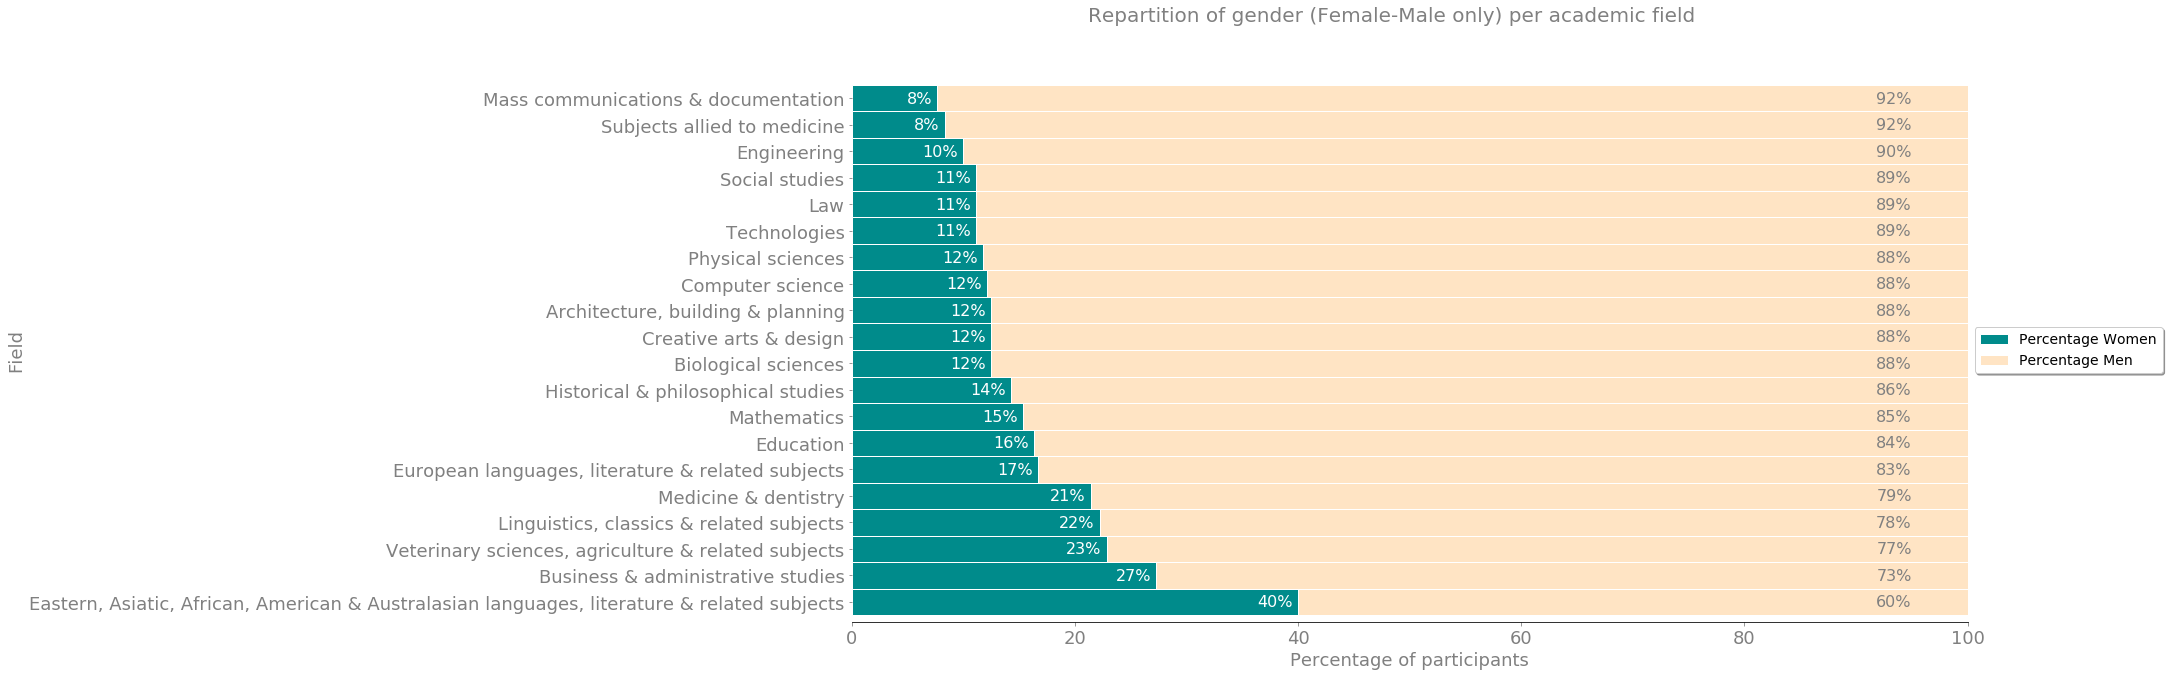

In [203]:
plot_bar_gender(gender_per_field, title='Repartition of gender (Female-Male only) per academic field', x_title = 'Field', y_title = 'Percentage of participants' );

## Leading role

### All

In [204]:
leading_table = pd.crosstab(df['Gender'], df['Leading RSE group'])

In [205]:
leading_table
leading_table.to_csv('./gender_difference/data/contengency_table_leader.csv', index=True)

Leading RSE group,No,Yes
Gender,,
Female,89,16
Male,560,124


In [206]:
# Source: https://machinelearningmastery.com/chi-squared-test-for-machine-learning/
stat, p, dof, expected = chi2_contingency(leading_table)
print('stat= {}'.format(stat))
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

stat= 0.3418634044526905
dof=1
[[ 86.36882129  18.63117871]
 [562.63117871 121.36882129]]
probability=0.950, critical=3.841, stat=0.342
Independent (fail to reject H0)
significance=0.050, p=0.559
Independent (fail to reject H0)


# Difference in satisfaction at work

## Setting up

In [207]:
satis_gen = ['Satisfaction current position', 
             'Satisfaction with career']

recog = ['recog1. Do you feel that your contribution to research is recognised by your supervisor/line manager',
         'recog2. Do you feel that your contribution to research is recognised by the researchers you work with',
         'recog3. Do you feel that your contribution to research is recognised by your institution?']

turn_over1 = ['turnOver3. How often do you consider leaving your job?']
turn_over2 = ['turnOver6. I would accept another job at the same compensation level if I was offered it']
turn_over = turn_over1 + turn_over2
perc_emp =['percEmp1. It would not be very difficult for me to get an equivalent job in a different institution',
           'percEmp3. My experience is in demand on the labour market']

prog_rse = ['progRSE1. It is likely that I will gain a promotion within my current group',
            'progRSE2. The process I have to complete to gain a promotion is clear and understandable',
            'progRSE3. There are many opportunities within my chosen career plan',
            'progRSE5. It is likely that my next position will be an Research Software Engineer / Research Software Developer role']

### Plotting the different likert scale by gender

In [208]:
replace_agree = {'Strongly disagree': 'Negative',
                 'Disagree': 'Negative', 
                 'Neither agree or disagree': 'Neutral',
                 'Agree': 'Positive',
                 'Strongly Agree': 'Positive'}

replace_satis_10 = {'\ufeff0 - Not at all satisfied': 'Negative' ,
                     '1': 'Negative',
                     '2': 'Negative',
                     '3': 'Negative',
                     '4': 'Neutral',
                     '5': 'Neutral',
                     '6': 'Neutral',
                     '7': 'Positive', 
                     '8': 'Positive', 
                     '9': 'Positive', 
                     '10 - Completely satisfied': 'Positive'}

replace_agree_inv = {'Strongly disagree': 'Negative',
                     'Disagree': 'Negative', 
                     'Neither agree or disagree': 'Neutral',
                     'Agree': 'Positive',
                     'Strongly Agree': 'Positive'}

replace_time_10 = {'\ufeff1 (None at all)': 'Negative', 
                   '1': 'Negative',
                   '2': 'Negative',
                   '3': 'Negative',
                   '4': 'Neutral',
                   '5': 'Neutral',
                   '6': 'Neutral',
                   '7': 'Positive',
                   '8': 'Positive',
                   '9': 'Positive',
                   '10 (All the time)': 'Positive'}

satis_gen_neutral = ['{} [neutral]'.format(i) for i in satis_gen]
recog_neutral = ['{} [neutral]'.format(i) for i in recog]
prog_rse_neutral = ['{} [neutral]'.format(i) for i in prog_rse]
perc_emp_neutral = ['{} [neutral]'.format(i) for i in neutral]
turn_over_neutral = ['{} [neutral]'.format(i) for i in turn_over]
turn_over1_neutral = ['{} [neutral]'.format(i) for i in turn_over1]
turn_over2_neutral = ['{} [neutral]'.format(i) for i in turn_over2]

In [212]:
df[satis_gen_neutral] = df[satis_gen].replace(replace_satis_10)
df[recog_neutral] = df[recog_neutral].replace(replace_satis_10)

df[prog_rse_neutral] = df[prog_rse].replace(replace_agree)
df[] = df[perc_emp].replace(replace_agree)
df_neutral.loc[:, turn_over1] = df[turn_over1].replace(replace_time_10)

df_neutral.loc[:, turn_over2] = df[turn_over2].replace(replace_agree)

In [211]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'submitdate. Date submitted',
       'lastpage. Last page', 'startlanguage. Start language',
       'startdate. Date started', 'socio1. In which country do you work?',
       'rse1. Do you write software for academic research as part of your job',
       'edu1. What is the highest level of education you have attained?',
       'edu4. List any professional qualifications you hold (eg. P. Eng, PMP, …)?',
       ...
       '[OTHER_RAW]. socio13ausnzlqaus[other]._.What is your pay-level? [Other]',
       '[OTHER_RAW]. org2can[other]._.What would you hope to get out of such an organisation (check all that apply)? [Other]',
       '[OTHER_RAW]. tool2[other]._.Which operating system do you primarily use for development? [Other]',
       '[OTHER_RAW]. tool4can[other]._.What programming languages do you use at work? Please select all that apply. [Other]',
       'Year', 'Country', 'Date', 'Field of education',
       'Satisfaction current position_neutral',


In [171]:
# TODO: accept several list of likert
def plotting_likert(df, columns, category, type_orga='horizontal', order_scale=None):
    """"""
    nbr_plots = 2

    if type_orga == 'vertical':
        fig, axs = plt.subplots(nbr_plots, 1, sharex=True, figsize=(30, 30))
    else:
        fig, axs = plt.subplots(1, nbr_plots, sharey=True, figsize=(30, 10))
    list_plots = list()
    df_female = df[df['Gender'] == 'Female'].loc[:, columns].copy()
    df_male = df[df['Gender'] == 'Male'].loc[:, columns].copy()
    for i, to_plot in enumerate(zip(('Women', 'Men'), [df_female, df_male])):
        gender = to_plot[0]
        df = to_plot[1]
        try:
            axs[i] = likert_scale(count_likert(df, order_scale).transpose(), normalise=True, legend=True, title_plot='{}'.format(category), ax=axs[i])
            axs[i].set_title(gender, fontsize=20)
            list_plots.append(axs[i])  
        
        except TypeError:
            axs = likert_scale(count_likert(df, order_scale).transpose(), normalise=True, legend=True, title_plot='{}'.format(category), ax=axs)
            axs.set_title(gender, fontsize=16)
            list_plots.append(axs)

    for ax in list_plots:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_legend().remove()
        ax.invert_yaxis()
    plt.tight_layout()


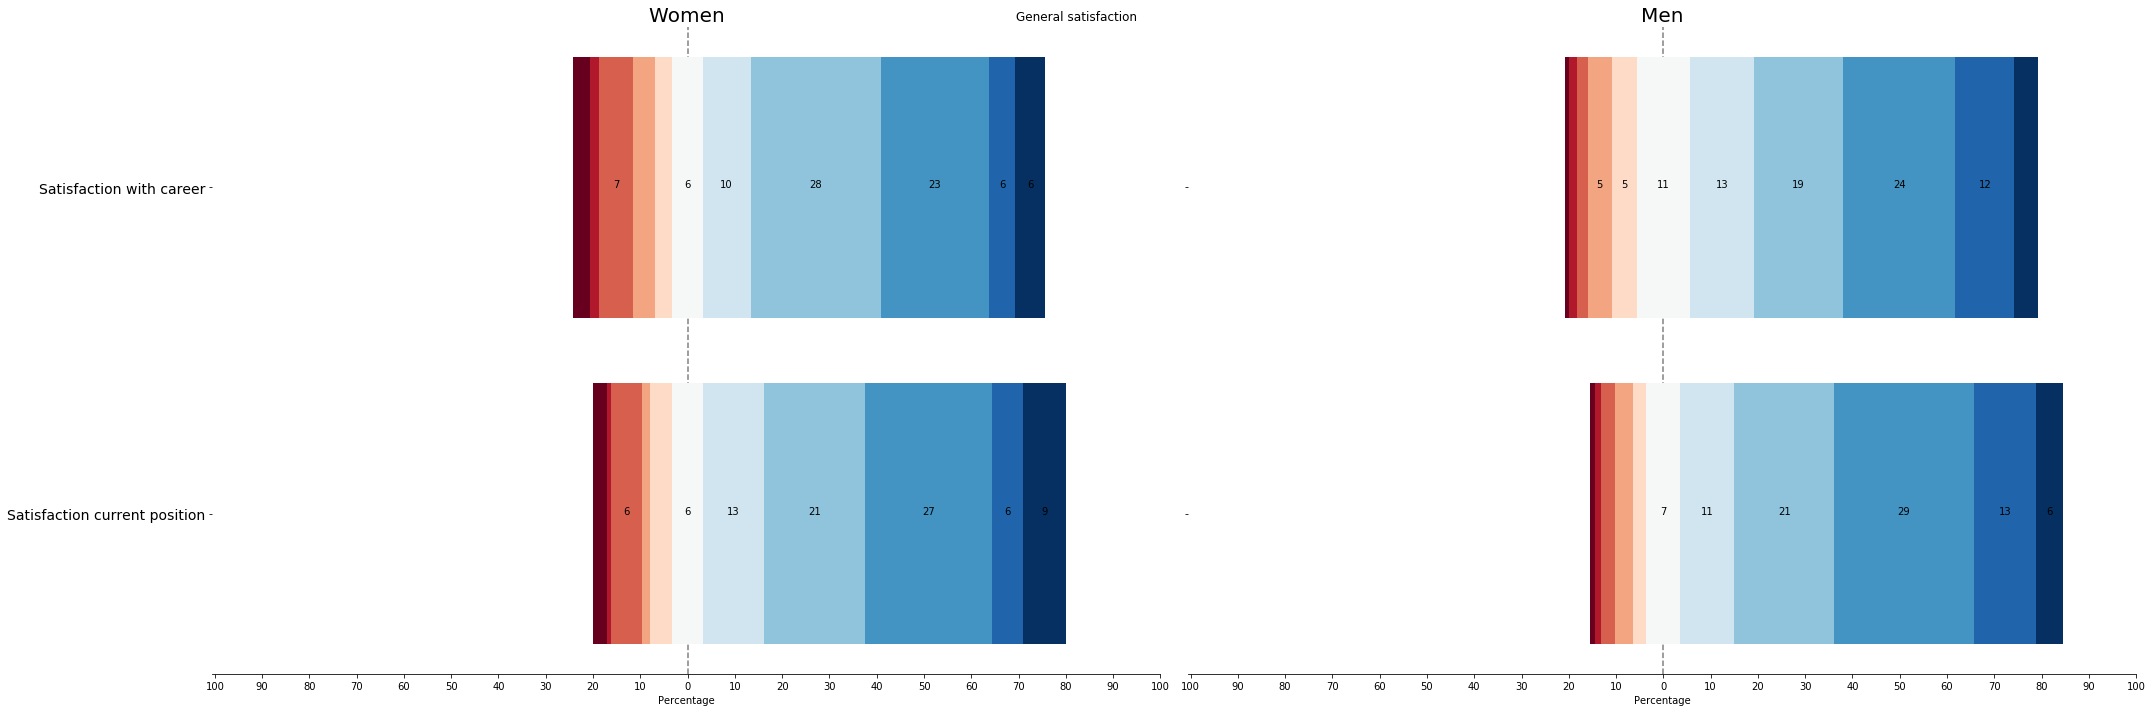

In [172]:
plotting_likert(df, satis_gen, category='General satisfaction', order_scale=replace_satis_10.keys())

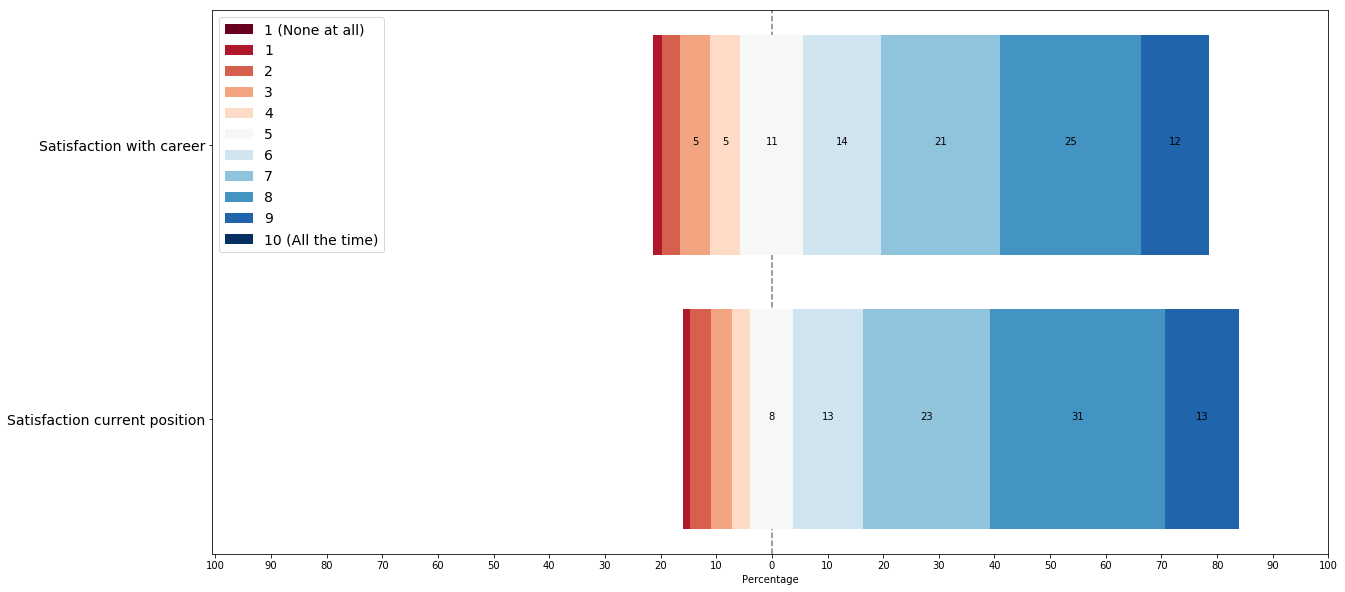

In [90]:
plotting_likert(df, recog, category='Recognition', order_scale=replace_agree.keys())

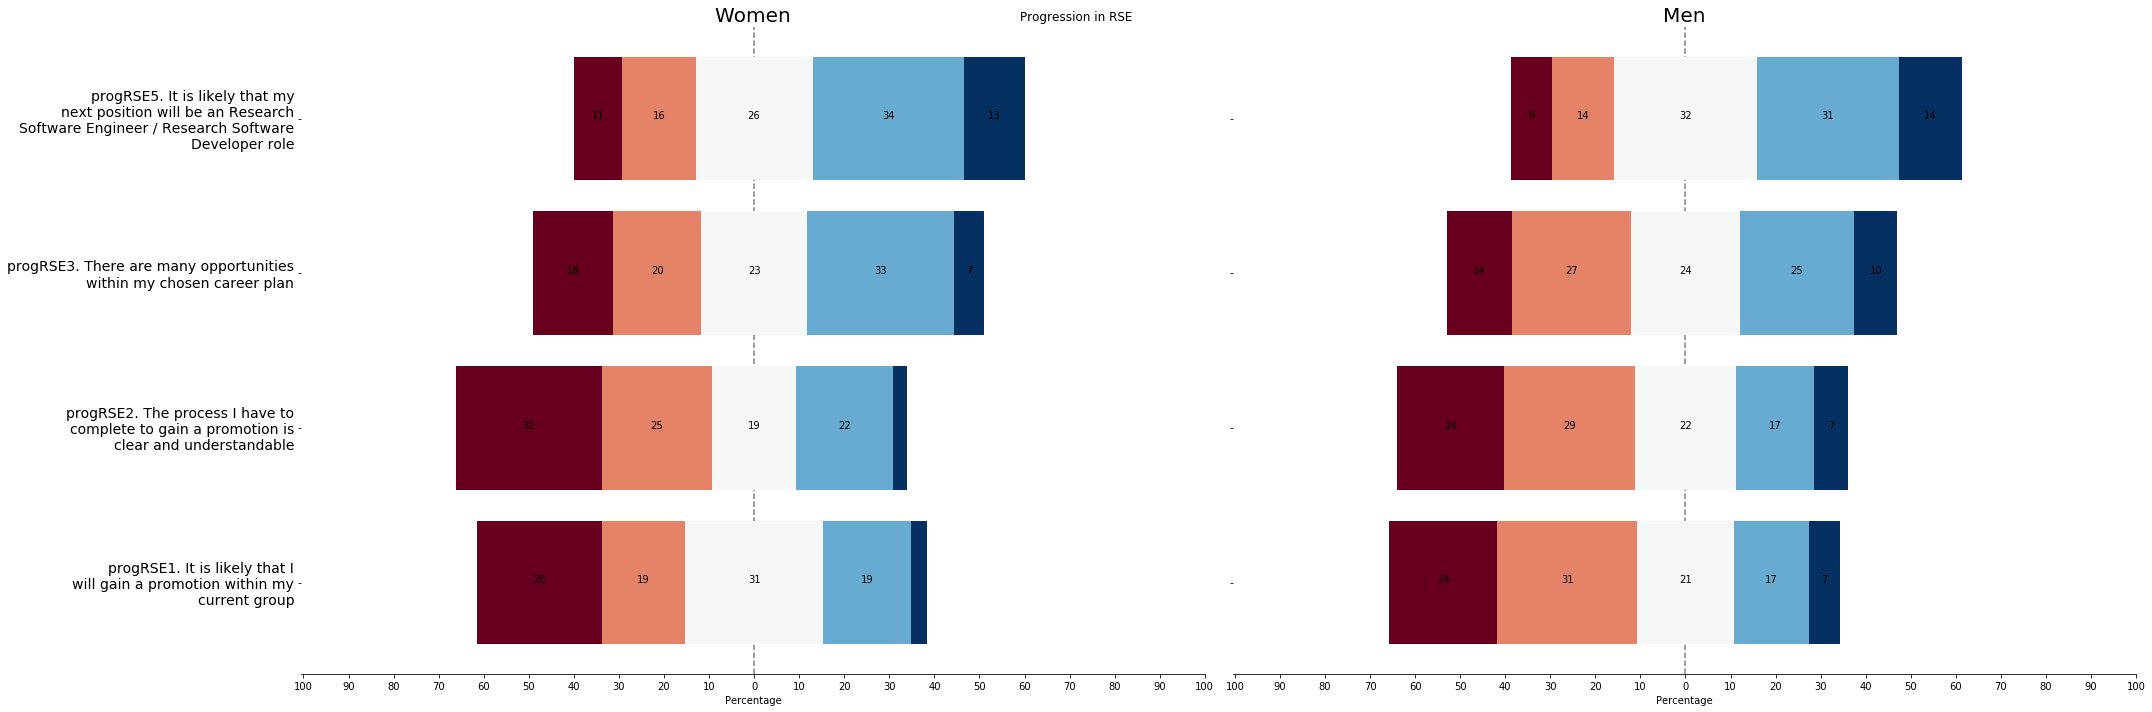

In [173]:
plotting_likert(df, prog_rse, category='Progression in RSE', order_scale=replace_agree.keys())

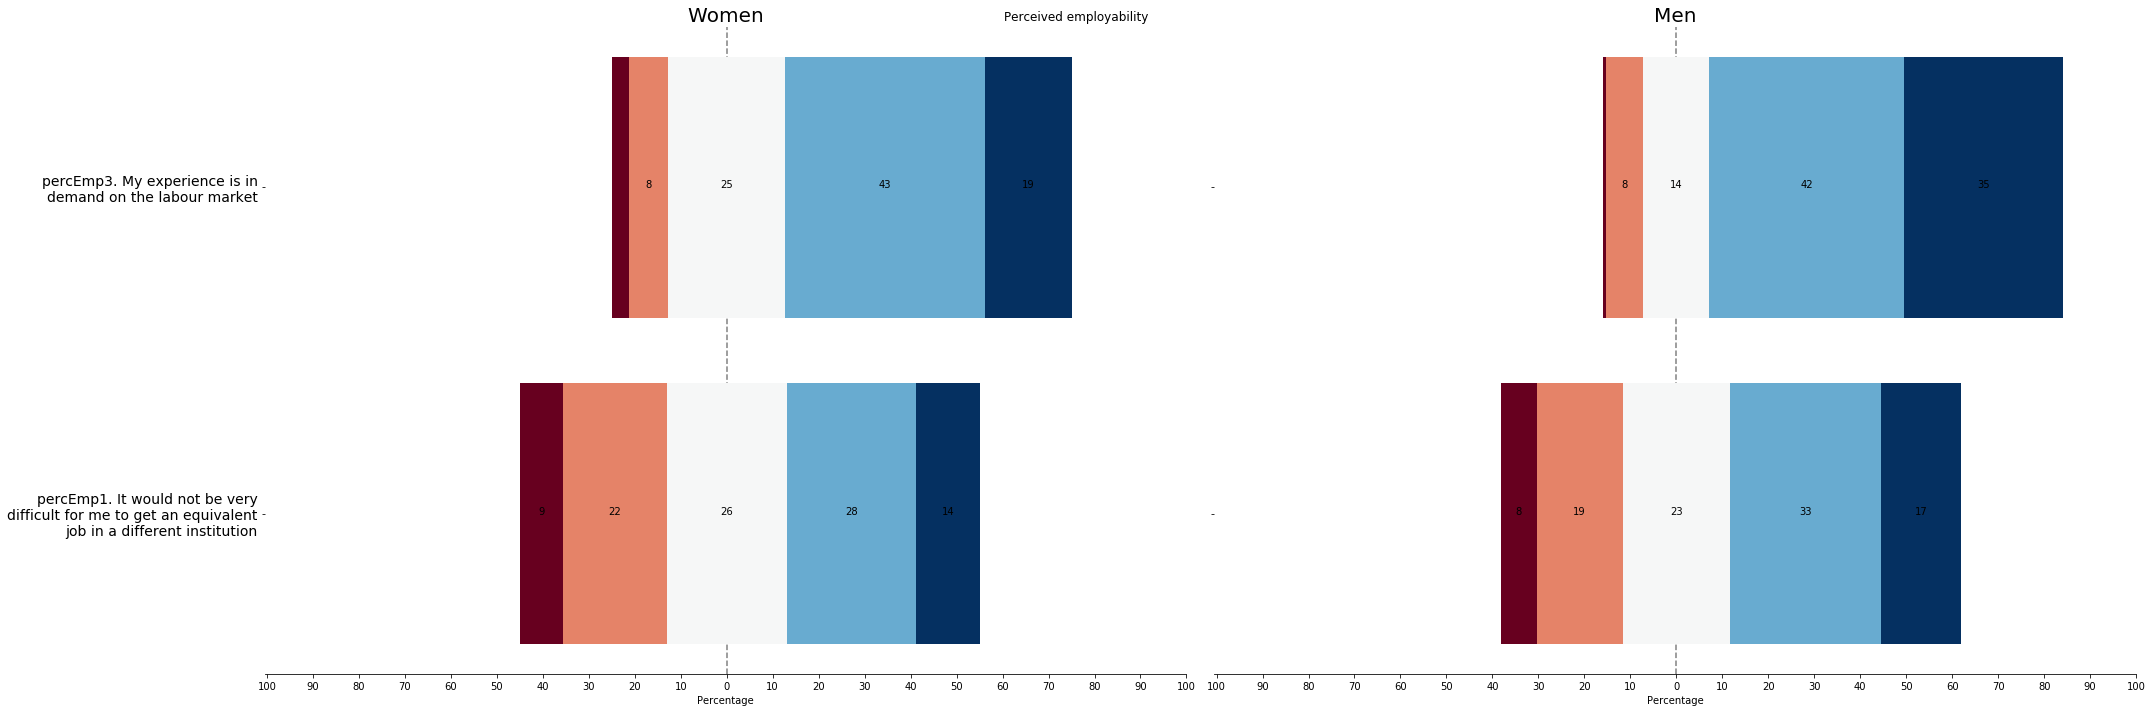

In [174]:
plotting_likert(df, perc_emp, category='Perceived employability', order_scale=replace_agree.keys())

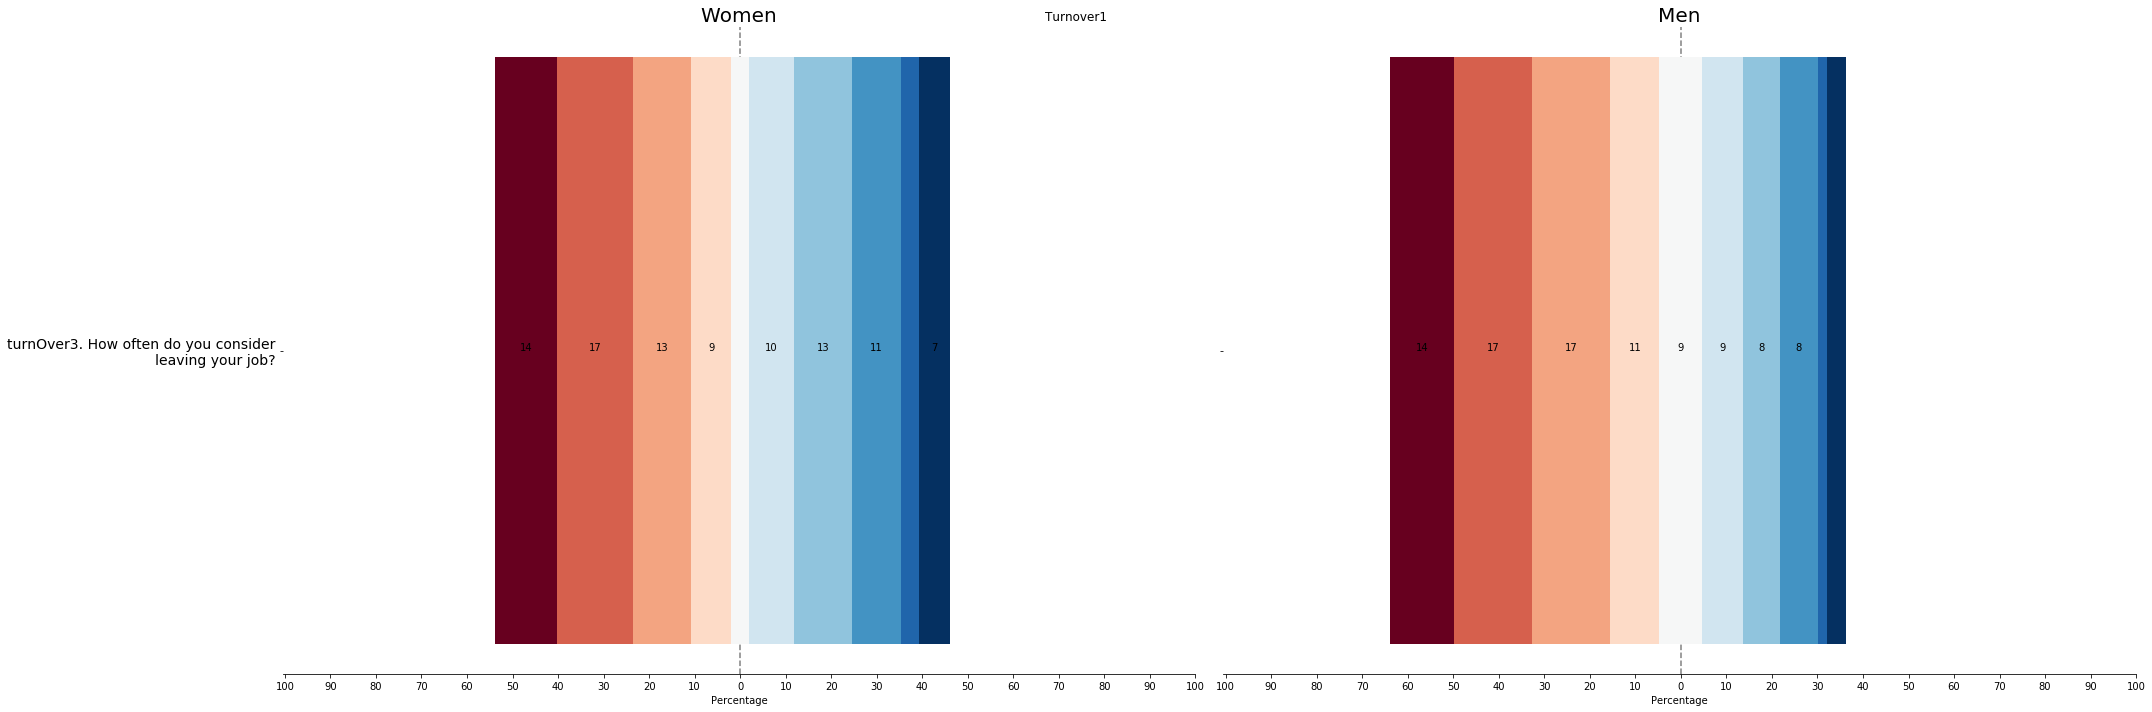

In [175]:
plotting_likert(df, turn_over1, category='Turnover1', order_scale=replace_time_10.keys())

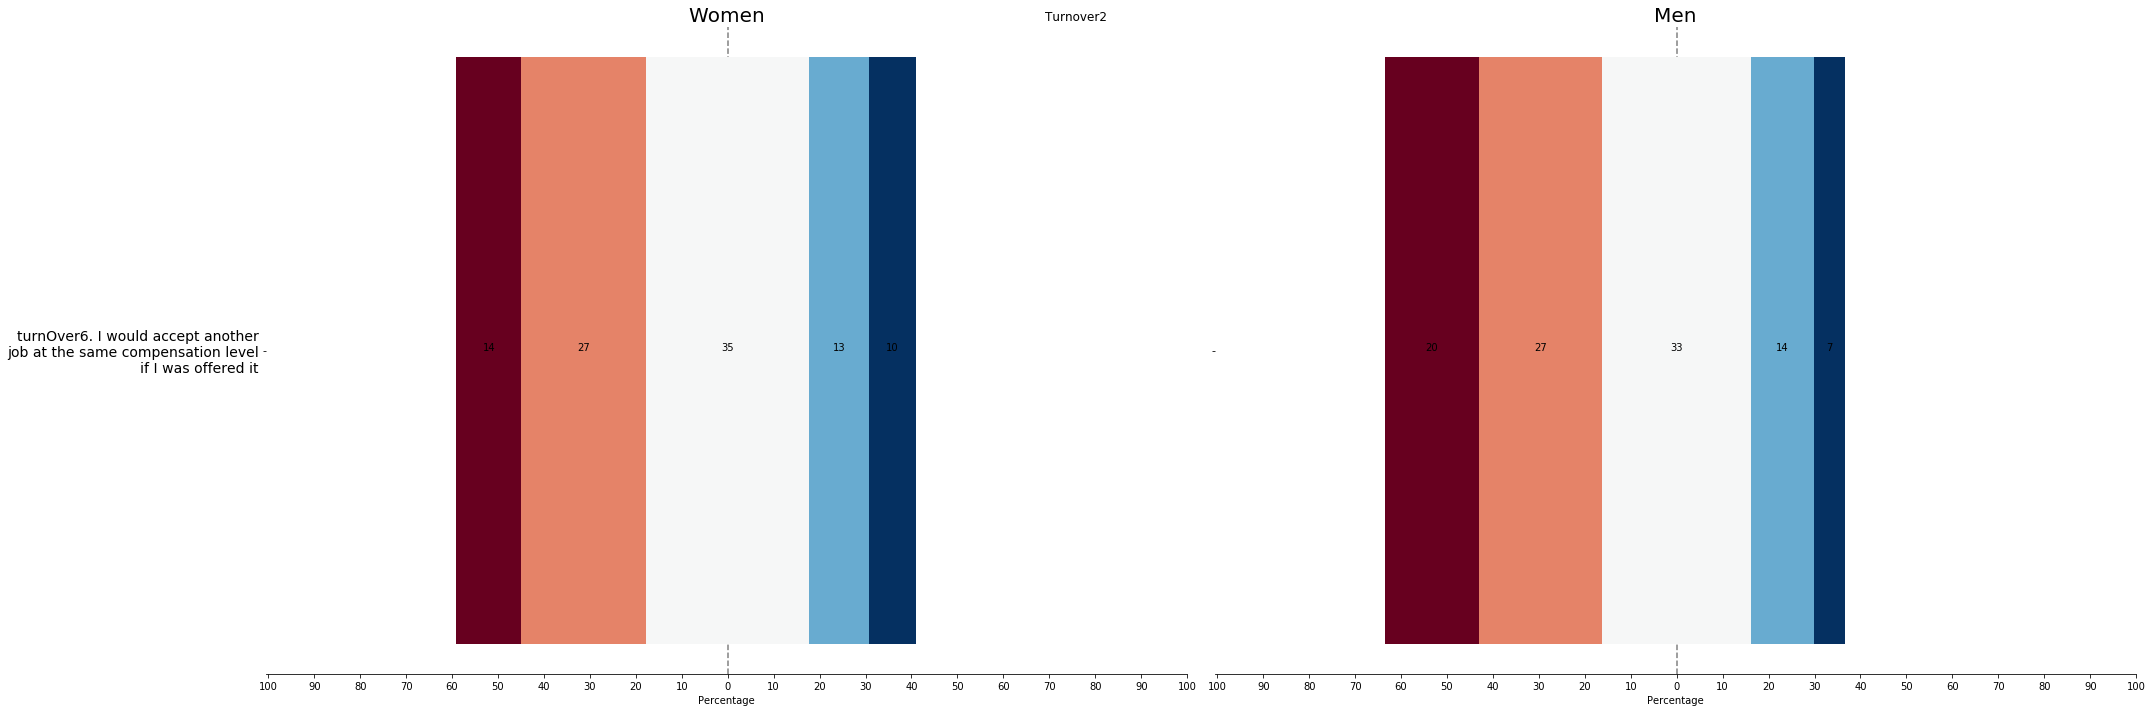

In [176]:
plotting_likert(df, turn_over2, category='Turnover2', order_scale=replace_agree.keys())

## Aggregating the items

In [177]:
replace_agree = {'Strongly disagree': 0 ,
                 'Disagree': 2.5, 
                 'Neither agree or disagree': 5,
                 'Agree': 7.5,
                 'Strongly Agree': 10}

replace_satis_10 = {'\ufeff0 - Not at all satisfied': 0 ,
                     '1': 1,
                     '2': 2,
                     '3': 3,
                     '4': 4,
                     '5': 5,
                     '6': 6,
                     '7': 7, 
                     '8': 8, 
                     '9': 9, 
                     '10 - Completely satisfied': 10}

replace_agree_inv = {'Strongly disagree': 10,
                     'Disagree': 7.5, 
                     'Neither agree or disagree': 5,
                     'Agree': 2.5,
                     'Strongly Agree': 0}

replace_time_10 = {'\ufeff1 (None at all)': 0, 
                   '1': 1,
                   '2': 2,
                   '3': 3,
                   '4': 4,
                   '5': 5,
                   '6': 6,
                   '7': 7,
                   '8': 8,
                   '9': 9,
                   '10 (All the time)': 10}

In [178]:
df.loc[:,satis_gen] = df[satis_gen].replace(replace_satis_10)
df.loc[:, recog] = df[recog].replace(replace_agree)
df.loc[:, prog_rse] = df[prog_rse].replace(replace_agree)
df.loc[:, perc_emp] = df[perc_emp].replace(replace_agree)
df.loc[:, turn_over1] = df[turn_over1].replace(replace_time_10)

df.loc[:, turn_over2] = df[turn_over2].replace(replace_agree)

In [179]:
df['Career_satisfaction_agg'] = df[satis_gen].mean(axis=1)#apply(zscore).mean(axis=1)
df['Recognition_agg'] = df[recog].mean(axis=1)#apply(zscore).mean(axis=1)
df['Progression_agg'] = df[prog_rse].mean(axis=1)#apply(zscore).mean(axis=1)
df['Employability_agg'] = df[perc_emp].mean(axis=1)#apply(zscore).mean(axis=1)
df['Turnover_intention_agg'] = df[turn_over].mean(axis=1)#apply(zscore).mean(axis=1)

In [180]:
#df['Recognition'] = pd.cut(['Recognition_agg'], 3, labels=["Negative", "Neutral", "Positive"])

## Aggregate possible progression
#df['Progression'] = pd.cut(progress, 3, labels=["Negative", "Neutral", "Positive"])

## Aggregate perceived employability
#df['Employability'] = pd.cut(employability, 3, labels=["Negative", "Neutral", "Positive"])

In [181]:
df_job_sat = df.groupby('Gender')[['Career_satisfaction_agg', 'Recognition_agg', 'Progression_agg', 'Employability_agg', 'Turnover_intention_agg']].mean()#.reset_index()
df_job_sat

,Career_satisfaction_agg,Recognition_agg,Progression_agg,Employability_agg,Turnover_intention_agg
Gender,,,,,
Female,6.435780,6.278317,4.378823,6.009174,4.558824
Male,6.787464,6.910964,4.501944,6.677680,4.036936


In [182]:
df_job_sat_plot = df_job_sat.reset_index().melt(id_vars=['Gender'])
df_job_sat_plot

,Gender,variable,value
0,Female,Career_satisfaction_agg,6.435780
1,Male,Career_satisfaction_agg,6.787464
2,Female,Recognition_agg,6.278317
3,Male,Recognition_agg,6.910964
4,Female,Progression_agg,4.378823
5,Male,Progression_agg,4.501944
6,Female,Employability_agg,6.009174
7,Male,Employability_agg,6.677680
8,Female,Turnover_intention_agg,4.558824
9,Male,Turnover_intention_agg,4.036936


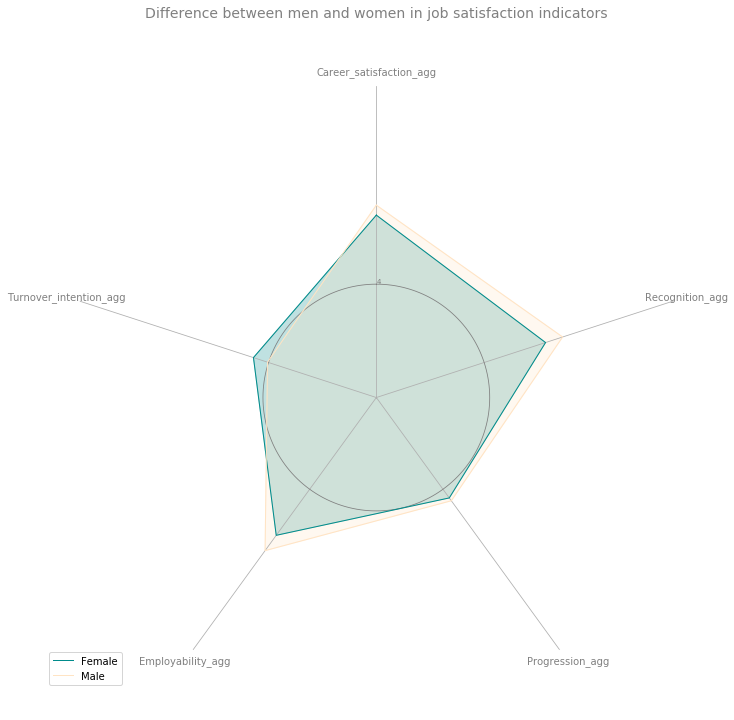

In [183]:
plot = radar_plotting(df_job_sat, title='Difference between men and women in job satisfaction indicators', color=['darkcyan', 'bisque'], percentage=False)
plot.savefig('./gender_difference/plots/job_sat_radar.png')


## References
Here the references that are not directly linked within the text:
* [1] http://rse.ac.uk/who/
* [2] PySankey: https://github.com/anazalea/pySankey